In [1]:
# imports
import torch
import sys
from pathlib import Path
import matplotlib.pyplot as plt

path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))

from src.baselineGP import *
from src.kernels import *
from src.dgps import *
from src.CBO import *
from src.kernel_utils import *

In [2]:
n = 100
n_int = 100 
seed = 8
two_datasets = True

torch.manual_seed(seed)

""" baselinegp configs"""
niter = 1000
learn_rate = 0.1
single_kernel = False
force_PD = True
reg = 1e-3
error_samples = 100
gp_samples = 100
Kernel = GaussianKernel

""" CBO configs """
int_samples = 10**5
n_iter = 20
xi = 0.0
update_hyperparameters = False
noise_init = -1.0
cbo_reg = 1e-3

In [34]:
""" Draw int data """
dostatin = torch.linspace(0,1,n_int)
age, bmi, aspirin, statin, cancer, psa = STATIN_PSA(int_samples, 
                                                    seed = seed, 
                                                    gamma = False, 
                                                    interventional_data = True, 
                                                    dostatin = dostatin)
psa,fvol, vol = PSA_VOL(psa = psa)  

""" Draw training data"""
age_, bmi_, aspirin_, statin_, cancer_, psa_ = STATIN_PSA(n, 
                                                          seed = seed, 
                                                          gamma = False, 
                                                          interventional_data = False, 
                                                          dostatin=[])
if two_datasets:
    age_2, bmi_2, aspirin_2, statin_2, cancer_2, psa_2 = STATIN_PSA(n, 
                                                      seed = seed, 
                                                      gamma = False, 
                                                      interventional_data = False, 
                                                      dostatin=[])
    psa_, fvol_, vol_ = PSA_VOL(psa = psa_2)
    A = torch.column_stack((age_, bmi_, aspirin_, statin_))
    V = [psa_.reshape(len(psa_),1), psa_2.reshape(len(psa_),1)]
    Y = vol_
    
else:
    psa_, fvol_, vol_ = PSA_VOL(psa = psa_)
    A = torch.column_stack((age_, bmi_, aspirin_, statin_))
    V = [psa_.reshape(len(psa_),1), psa_.reshape(len(psa_),1)]
    Y = vol_
    
""" Initialise model """
model = baselineGP(Kernel_A = Kernel, 
               Kernel_V = Kernel, 
               Kernel_Z = [],
               dim_A = A.size()[1], 
               dim_V = V[1].size()[1], 
               single_kernel = single_kernel,
               scale_V_init = Y.var()**0.5/2,
               noise_Y_init = torch.log(Y.var()/4)/10)
                   
""" Train model """
model.train(Y,A,V,niter,learn_rate, force_PD = force_PD)

/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/baselineGP.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor(scale_V_init, requires_grad = True))
/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/baselineGP.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.noise_Y = torch.tensor(noise_Y_init, requires_grad = True).float()


iter 0 P(Y|V) loss:  tensor(473.4602)
iter 100 P(Y|V) loss:  tensor(168.8266)
iter 200 P(Y|V) loss:  tensor(168.5399)
iter 300 P(Y|V) loss:  tensor(168.3867)
iter 400 P(Y|V) loss:  tensor(168.2848)
iter 500 P(Y|V) loss:  tensor(168.2103)
iter 600 P(Y|V) loss:  tensor(168.1528)
iter 700 P(Y|V) loss:  tensor(168.1068)
iter 800 P(Y|V) loss:  tensor(168.0691)
iter 900 P(Y|V) loss:  tensor(168.0375)
iter 0 P(V|A) loss:  tensor(294.1905)
iter 100 P(V|A) loss:  tensor(50.5981)
iter 200 P(V|A) loss:  tensor(43.9850)
iter 300 P(V|A) loss:  tensor(40.7673)
iter 400 P(V|A) loss:  tensor(38.7755)
iter 500 P(V|A) loss:  tensor(37.4017)
iter 600 P(V|A) loss:  tensor(36.4912)
iter 700 P(V|A) loss:  tensor(35.8914)
iter 800 P(V|A) loss:  tensor(35.4753)
iter 900 P(V|A) loss:  tensor(35.1684)


In [38]:
doX.size()

torch.Size([100, 1])

In [35]:
EYdoX_samples, EVdoX_samples = model.marginal_post_sample(Y,V,A,doX, 
                                                        reg = reg, 
                                                        error_samples = error_samples*10, 
                                                        gp_samples = gp_samples)

In [33]:
torch.log(Y.var()/4)

tensor(0.9105)

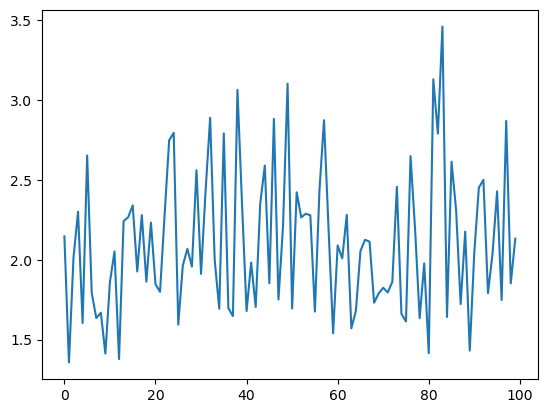

In [36]:
plt.plot(EYdoX_samples.var(1))

In [4]:
# main
""" Get CBO prior kernel """
def mean(X):
    EYdoX_samples, EVdoX_samples = model.marginal_post_sample(Y,V,A,X, 
                                                        reg = reg, 
                                                        error_samples = error_samples, 
                                                        gp_samples = gp_samples)
    return EYdoX_samples.mean(1)[:,None]
        
def var(X, diag = False):
    EYdoX_samples, EVdoX_samples = model.marginal_post_sample(Y,V,A,X, 
                                                        reg = reg, 
                                                        error_samples = error_samples, 
                                                        gp_samples = gp_samples)
    return EYdoX_samples.var(1)[:,None]

        
medheur = median_heuristic(statin[:,None].reshape(n_int,int_samples).mean(1)[:,None])
rbf_kernel = GaussianKernel(lengthscale=torch.tensor([medheur]).requires_grad_(True), 
                        scale=torch.tensor([vol.var()**0.5]).requires_grad_(True))
cbo_kernel = CausalKernel(
    estimate_var_func=var,
    base_kernel=rbf_kernel,
    add_base_kernel=True
)

""" Run CBO """
# Define a grid of intervention points and precompute E[Y|do(x)]
doX = dostatin[:,None]
EYdoX = fvol.reshape(n_int,int_samples).mean(1)[:,None]

# Random search for first intervention point
torch.manual_seed(seed)
start = torch.randint(0,99,(1,))[0]
doXtrain, EYdoXtrain = doX[start].reshape(1,1), EYdoX[start].reshape(1,1)

# Run CBO iters
doXeval, EYdoXeval = causal_bayesian_optimization(X_train = doXtrain, 
                                                    y_train = EYdoXtrain, 
                                                    kernel = cbo_kernel, 
                                                    mean = lambda x : torch.ones(len(x),1)*EYdoX.mean(),
                                                    X_test = doX, 
                                                    Y_test = EYdoX, 
                                                    n_iter = n_iter, 
                                                    update_hyperparameters = update_hyperparameters,
                                                    xi = xi, 
                                                    print_ = False, 
                                                    minimise = True,
                                                    noise_init = noise_init,
                                                    reg = cbo_reg)